In this notebook, I use **vgg19** pre-trained model to do artistic style transfer.

The idea of artistic style transfer is to obtain a representation of the style of an input image and apply the style to another image while keeping the original image content recognizable.

## Dependencties

In [2]:
import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg19
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline

## Define Constants

In [3]:
# image file path
CONTENT_IMG_PATH= 'glass_church.jpg'
STYLE_IMG_PATH = 'oil.jpg'
# if want to keep tarining a previous image, change CONTENT_IMG_PATH to the previous image path
START_IMG_PATH = CONTENT_IMG_PATH 

# Number of iterations to run
ITER = 10

# Weights of losses
CONTENT_WEIGHT = 2 
STYLE_WEIGHT = 10
TV_WEIGHT = 0.1

# Define the shape of the otput image
w, h = load_img(CONTENT_IMG_PATH).size
print('content_img width and height:', w,h)
img_h = 400
img_w = int(w * img_h / h)
print('gen_img width and height:', img_w, img_h)

content_img width and height: 660 371
gen_img width and height: 711 400


## Visualize content and style image

In [4]:
def visualize_image(img_path):
    img = plt.imread(img_path)
    plt.xticks([])
    plt.yticks([])
    plt.title(img.shape)
    plt.imshow(img);

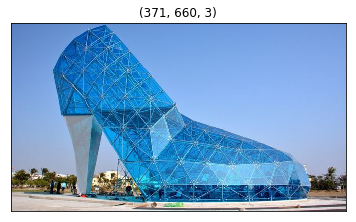

In [5]:
visualize_image(CONTENT_IMG_PATH)

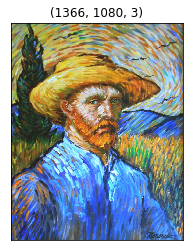

In [6]:
visualize_image(STYLE_IMG_PATH)

## Pre-process the Data

In [7]:
def preprocess(img_path):
    # loads RGB image from img_path
    img = load_img(img_path)
    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape array to 3D tensor
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    # convert 3D tensor to 4D tensor 
    img = np.expand_dims(img, axis=0)
    # prepare the image for the VGG model
    img = vgg19.preprocess_input(img)
    return img

## Build the model

The input_tensor's shape is (3, height, width, channels or filters).

    * input_tensor[0]: content_img
    * input_tensor[1]: the style_img
    * input_tensor[2]: the gen_img

In [8]:
content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))
gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# combines three arrays into a single array 
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


In [9]:
# we are only interested in the convolutional layers which are the feature extraction layers =>
# include_top=False
model = vgg19.VGG19(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('Model loaded')

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded


In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (3, 400, 711, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 400, 711, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 400, 711, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 200, 355, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 200, 355, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 200, 355, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 100, 177, 128)        0         
__________

<img src="assets/vgg19.jpg" alt="vgg19 architecture">

## Calculate losses

### 1. Content loss

The content loss is the Mean Squared Error of the feature activation in the content image and the generated image.

In [10]:
def calc_content_loss(outputs_dict, content_layer_names):
    loss = 0. # initialize loss
    for name in content_layer_names:
        layer_features = outputs_dict[name]
        content_img_features = layer_features[0, :, :, :]
        gen_img_features = layer_features[2, :, :, :]
        loss += K.sum(K.square(gen_img_features - content_img_features))/len(content_layer_names)
    return loss

In [11]:
content_layer_names = ['block5_conv2']
content_loss = calc_content_loss(outputs_dict, content_layer_names)

### 2. Style loss

The style loss is the Squared Error for the Gram-matrices in the style layers.

When style features and generated features have similar Gram matrices, they have similar styles.

In [12]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def calc_style_loss(outputs_dict, feature_layer_names):
    style_loss = 0.
    for name in feature_layer_names:
        layer_features = outputs_dict[name]
        style_features = layer_features[1, :, :, :]
        gen_img_features = layer_features[2, :, :, :]
        
        assert K.ndim(style_features) == 3
        assert K.ndim(gen_img_features) == 3
        S = gram_matrix(style_features)
        G = gram_matrix(gen_img_features)
        channels = 3
        size = img_h * img_w
        style_loss += (K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2)))/len(feature_layer_names)
    return style_loss

In [13]:
feature_layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
style_loss = calc_style_loss(outputs_dict, feature_layer_names)

### 3. Total variance loss

The total variance loss is the difference between the neighboring pixel values.

Penalize wiggles or variation in the pixel values to smooth the generated image. 

In [14]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    row_diff = K.square(x[:,:-1,:-1,:] - x[:,1:  , :-1,:])
    col_diff = K.square(x[:,:-1,:-1,:] - x[:, :-1,1:  ,:])
    return K.sum(K.pow(row_diff + col_diff, 1.25))

In [15]:
variation_loss= total_variation_loss(gen_img)
loss = CONTENT_WEIGHT * content_loss + STYLE_WEIGHT * style_loss + TV_WEIGHT * variation_loss

## Evaluating the gradients and loss

In [16]:
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_output = K.function([gen_img], outputs)


def eval_loss_and_grads(x):
    x = x.reshape((1, img_h, img_w, 3))

    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## Deprocess the image

Do the reverse of the preprocessing to display the generated image.

According to [imagenet_utils.py](https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py), all pixel values in the input images were substracted by mean pixels. Therefore, the intensities are centered at zero. It will help to increase training speed and accuracy.


We need to add the mean pixel value back for each pixel in each channel before outputing the generated image.

 
```python
# function in imagenet_utils.py
def _preprocess_numpy_input(x, data_format, mode, **kwargs):

    backend, _, _, _ = get_submodules_from_kwargs(kwargs)
    if not issubclass(x.dtype.type, np.floating):
        x = x.astype(backend.floatx(), copy=False)

    if mode == 'tf':
        x /= 127.5
        x -= 1.
        return x

    if mode == 'torch':
        x /= 255.
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    else:
        if data_format == 'channels_first':
            # 'RGB'->'BGR'
            if x.ndim == 3:
                x = x[::-1, ...]
            else:
                x = x[:, ::-1, ...]
        else:
            # 'RGB'->'BGR'
            x = x[..., ::-1]
        mean = [103.939, 116.779, 123.68]
        std = None

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] -= mean[0]
            x[1, :, :] -= mean[1]
            x[2, :, :] -= mean[2]
            if std is not None:
                x[0, :, :] /= std[0]
                x[1, :, :] /= std[1]
                x[2, :, :] /= std[2]
        else:
            x[:, 0, :, :] -= mean[0]
            x[:, 1, :, :] -= mean[1]
            x[:, 2, :, :] -= mean[2]
            if std is not None:
                x[:, 0, :, :] /= std[0]
                x[:, 1, :, :] /= std[1]
                x[:, 2, :, :] /= std[2]
    else:
        x[..., 0] -= mean[0]
        x[..., 1] -= mean[1]
        x[..., 2] -= mean[2]
        if std is not None:
            x[..., 0] /= std[0]
            x[..., 1] /= std[1]
            x[..., 2] /= std[2]
    return x
```

In [17]:
def unprocess_image(img):
    if K.image_data_format() == 'channels_first':
        # For Theano
        img = img.reshape((3, img_h, img_w))
        img = img.transpose((1, 2, 0))
    else:
        # tf as backend: batch, height, width, depth
        img = img.reshape((img_h, img_w, 3))
    # Remove zero-center by mean pixel
    # BGR_MEAN = [103.939, 116.779, 123.68]
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img

## Train and Run the model

In [18]:
def train(save_weights_path):
    evaluator = Evaluator()
    #start_img
    x = preprocess(START_IMG_PATH)
    result_prefix = 'gen_img'
    for i in range(ITER):
        print('Start of iteration', i)
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
        print('Current loss value:', min_val)
        # save current generated image
        img = unprocess_image(x.copy())
        fname = result_prefix + '_at_iteration_%d.png' % i
        imsave(fname, img)
        visualize_image(fname)
        end_time = time.time()
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
    model.save_weights(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 10 
    - TV_WEIGHT = 0.1
    
transfer style: **oil painting**

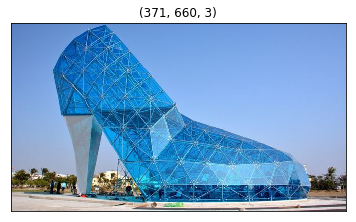

In [19]:
# content image
visualize_image('glass_church.jpg')

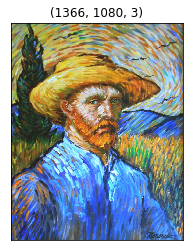

In [20]:
# style image
visualize_image('oil.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 15664421000.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 578s
Start of iteration 1
Current loss value: 7963560000.0
Iteration 1 completed in 625s
Start of iteration 2
Current loss value: 5666012700.0
Iteration 2 completed in 619s
Start of iteration 3
Current loss value: 4539693600.0
Iteration 3 completed in 590s
Start of iteration 4
Current loss value: 3777129700.0
Iteration 4 completed in 591s
Start of iteration 5
Current loss value: 3301883000.0
Iteration 5 completed in 580s
Start of iteration 6
Current loss value: 2931920600.0
Iteration 6 completed in 583s
Start of iteration 7
Current loss value: 2705411000.0
Iteration 7 completed in 587s
Start of iteration 8
Current loss value: 2499573000.0
Iteration 8 completed in 705s
Start of iteration 9
Current loss value: 2352797000.0
Iteration 9 completed in 916s


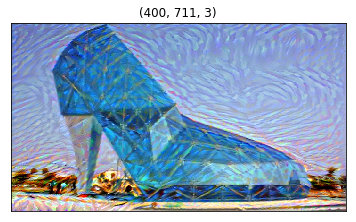

In [21]:
save_weights_path = 'save_model/Voil_model_weights.hdf5'
train(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 0.005 
    - TV_WEIGHT = 0.01
    
transfer style: **doodle art**

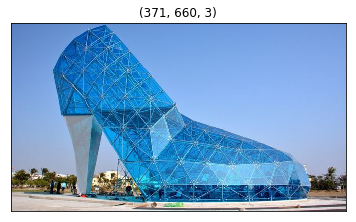

In [76]:
# content image
visualize_image('glass_church.jpg')

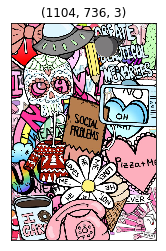

In [53]:
# style image
visualize_image('doodle2.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 1796433300.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 615s
Start of iteration 1
Current loss value: 1032524800.0
Iteration 1 completed in 697s
Start of iteration 2
Current loss value: 772682200.0
Iteration 2 completed in 731s
Start of iteration 3
Current loss value: 655369200.0
Iteration 3 completed in 711s
Start of iteration 4
Current loss value: 592771100.0
Iteration 4 completed in 703s
Start of iteration 5
Current loss value: 555026500.0
Iteration 5 completed in 706s
Start of iteration 6
Current loss value: 525906700.0
Iteration 6 completed in 753s
Start of iteration 7
Current loss value: 505293570.0
Iteration 7 completed in 713s
Start of iteration 8
Current loss value: 488754720.0
Iteration 8 completed in 750s
Start of iteration 9
Current loss value: 475935940.0
Iteration 9 completed in 764s


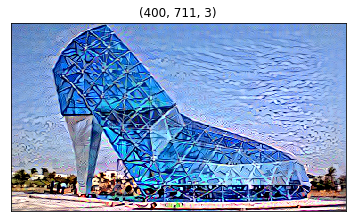

In [49]:
save_weights_path = 'save_model/Vdoodle_model_weights.hdf5'
train(save_weights_path)

## Retrain the model

1. Reload the saved model weights
2. Change the start image to the image we wants to keep training

In [50]:
model.load_weights('save_model/Vdoodle_model_weights.hdf5')

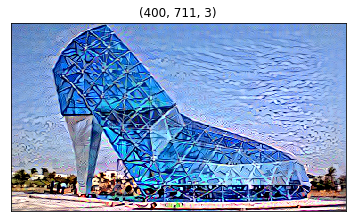

In [51]:
START_IMG_PATH = 'previous_img.png'
visualize_image(START_IMG_PATH)

### || Glass Church - iteration 11-20 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 0.005 
    - TV_WEIGHT = 0.01

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 549088060.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 787s
Start of iteration 1
Current loss value: 485863800.0
Iteration 1 completed in 777s
Start of iteration 2
Current loss value: 464107840.0
Iteration 2 completed in 708s
Start of iteration 3
Current loss value: 447230400.0
Iteration 3 completed in 737s
Start of iteration 4
Current loss value: 436039100.0
Iteration 4 completed in 779s
Start of iteration 5
Current loss value: 427905200.0
Iteration 5 completed in 681s
Start of iteration 6
Current loss value: 421556900.0
Iteration 6 completed in 710s
Start of iteration 7
Current loss value: 416358400.0
Iteration 7 completed in 770s
Start of iteration 8
Current loss value: 411942100.0
Iteration 8 completed in 760s
Start of iteration 9
Current loss value: 408172060.0
Iteration 9 completed in 708s


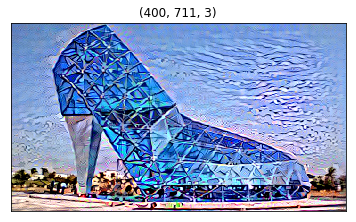

In [52]:
save_weights_path = 'save_model/Vdoodle_model_weights_20.hdf5'
train(save_weights_path)

=====================================================================================================================
### || Glass Church - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 1 
    - STYLE_WEIGHT = 2
    - TV_WEIGHT = 0.1
    
 transfer style: **sketch**

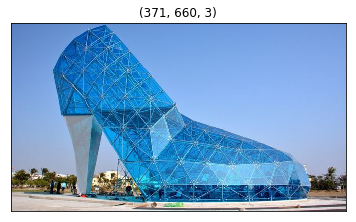

In [75]:
# content image
visualize_image('glass_church.jpg')

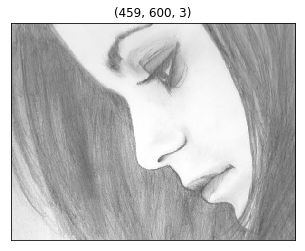

In [72]:
# style image
visualize_image('face_sketch.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 3826996200.0


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Iteration 0 completed in 639s
Start of iteration 1
Current loss value: 1623805700.0
Iteration 1 completed in 641s
Start of iteration 2
Current loss value: 1046872100.0
Iteration 2 completed in 712s
Start of iteration 3
Current loss value: 799741900.0
Iteration 3 completed in 788s
Start of iteration 4
Current loss value: 680152450.0
Iteration 4 completed in 734s
Start of iteration 5
Current loss value: 602155200.0
Iteration 5 completed in 638s
Start of iteration 6
Current loss value: 552973440.0
Iteration 6 completed in 637s
Start of iteration 7
Current loss value: 519203000.0
Iteration 7 completed in 653s
Start of iteration 8
Current loss value: 494066180.0
Iteration 8 completed in 638s
Start of iteration 9
Current loss value: 473389900.0
Iteration 9 completed in 659s


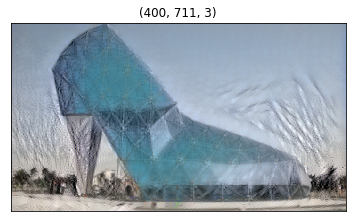

In [277]:
save_weights_path = 'save_model/Vsketch_model_weights.hdf5'
train(save_weights_path)

=====================================================================================================================
### || People - iteration 1-10 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 5e5
    - TV_WEIGHT = 10
    
transfer style: **people painting**

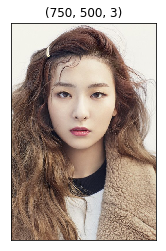

In [226]:
# content image
visualize_image('seulgi.jpg')

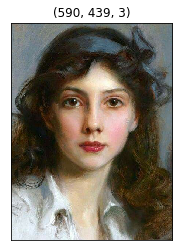

In [227]:
# style image
visualize_image('people-painting.jpg')

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 26467019000000.0
Iteration 0 completed in 248s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 13733357000000.0
Iteration 1 completed in 222s
Start of iteration 2
Current loss value: 10094914000000.0
Iteration 2 completed in 247s
Start of iteration 3
Current loss value: 8689316000000.0
Iteration 3 completed in 247s
Start of iteration 4
Current loss value: 7732770000000.0
Iteration 4 completed in 226s
Start of iteration 5
Current loss value: 7099171500000.0
Iteration 5 completed in 226s
Start of iteration 6
Current loss value: 6626057700000.0
Iteration 6 completed in 228s
Start of iteration 7
Current loss value: 6229415400000.0
Iteration 7 completed in 233s
Start of iteration 8
Current loss value: 5886313500000.0
Iteration 8 completed in 236s
Start of iteration 9
Current loss value: 5629184300000.0
Iteration 9 completed in 231s


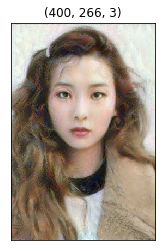

In [238]:
save_weights_path = 'save_model/Vpeople_model_weights.hdf5'
train(save_weights_path)

### || People - iteration 11-20 ||
    Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 5e5
    - TV_WEIGHT = 10

In [242]:
model.load_weights('save_model/Vpeople_model_weights.hdf5')

In [ ]:
START_IMG_PATH = 'previous_img.png'

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 5301821000000.0
Iteration 0 completed in 241s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 5038833000000.0
Iteration 1 completed in 245s
Start of iteration 2
Current loss value: 4807643000000.0
Iteration 2 completed in 228s
Start of iteration 3
Current loss value: 4561396000000.0
Iteration 3 completed in 227s
Start of iteration 4
Current loss value: 4364984000000.0
Iteration 4 completed in 227s
Start of iteration 5
Current loss value: 4234657400000.0
Iteration 5 completed in 232s
Start of iteration 6
Current loss value: 4100377300000.0
Iteration 6 completed in 224s
Start of iteration 7
Current loss value: 3959199000000.0
Iteration 7 completed in 223s
Start of iteration 8
Current loss value: 3843292400000.0
Iteration 8 completed in 230s
Start of iteration 9
Current loss value: 3741806200000.0
Iteration 9 completed in 270s


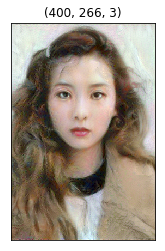

In [243]:
save_weights_path = 'save_model/Vpeople_model_weights_20.hdf5'
train(save_weights_path)

### || People - iteration 21-30 ||
     Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 5e5
    - TV_WEIGHT = 10

In [245]:
model.load_weights('save_model/Vpeople_model_weights_20.hdf5')

In [ ]:
START_IMG_PATH = 'previous_img.png'

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 3593245600000.0
Iteration 0 completed in 243s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 3485463500000.0
Iteration 1 completed in 233s
Start of iteration 2
Current loss value: 3390332700000.0
Iteration 2 completed in 222s
Start of iteration 3
Current loss value: 3321630000000.0
Iteration 3 completed in 269s
Start of iteration 4
Current loss value: 3262094200000.0
Iteration 4 completed in 239s
Start of iteration 5
Current loss value: 3205160800000.0
Iteration 5 completed in 233s
Start of iteration 6
Current loss value: 3156170200000.0
Iteration 6 completed in 226s
Start of iteration 7
Current loss value: 3100045700000.0
Iteration 7 completed in 222s
Start of iteration 8
Current loss value: 3026271600000.0
Iteration 8 completed in 235s
Start of iteration 9
Current loss value: 2970101700000.0
Iteration 9 completed in 235s


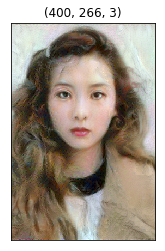

In [246]:
save_weights_path = 'save_model/Vpeople_model_weights_30.hdf5'
train(save_weights_path)

### || People - iteration 31-40 ||
     Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 1e6
    - TV_WEIGHT = 10

In [296]:
model.load_weights('save_model/Vpeople_model_weights_30.hdf5')

In [ ]:
START_IMG_PATH = 'previous_img.png'

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 28719520000000.0
Iteration 0 completed in 224s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 28212317000000.0
Iteration 1 completed in 217s
Start of iteration 2
Current loss value: 27684967000000.0
Iteration 2 completed in 222s
Start of iteration 3
Current loss value: 27128502000000.0
Iteration 3 completed in 217s
Start of iteration 4
Current loss value: 26660565000000.0
Iteration 4 completed in 218s
Start of iteration 5
Current loss value: 26253925000000.0
Iteration 5 completed in 221s
Start of iteration 6
Current loss value: 25891294000000.0
Iteration 6 completed in 222s
Start of iteration 7
Current loss value: 25551293000000.0
Iteration 7 completed in 214s
Start of iteration 8
Current loss value: 25237224000000.0
Iteration 8 completed in 218s
Start of iteration 9
Current loss value: 24811026000000.0
Iteration 9 completed in 215s


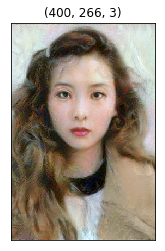

In [297]:
save_weights_path = 'save_model/Vpeople_model_weights_40.hdf5'
train(save_weights_path)

### || People - iteration 41-50 ||
     Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 1e6
    - TV_WEIGHT = 10

In [310]:
model.load_weights('save_model/Vpeople_model_weights_40.hdf5')

In [ ]:
START_IMG_PATH = 'previous_img.png'

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 265487770000000.0
Iteration 0 completed in 219s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 139804205000000.0
Iteration 1 completed in 209s
Start of iteration 2
Current loss value: 105133000000000.0
Iteration 2 completed in 210s
Start of iteration 3
Current loss value: 89563200000000.0
Iteration 3 completed in 218s
Start of iteration 4
Current loss value: 79870040000000.0
Iteration 4 completed in 225s
Start of iteration 5
Current loss value: 73307500000000.0
Iteration 5 completed in 233s
Start of iteration 6
Current loss value: 67229630000000.0
Iteration 6 completed in 228s
Start of iteration 7
Current loss value: 62740475000000.0
Iteration 7 completed in 216s
Start of iteration 8
Current loss value: 59351197000000.0
Iteration 8 completed in 221s
Start of iteration 9
Current loss value: 56803623000000.0
Iteration 9 completed in 230s


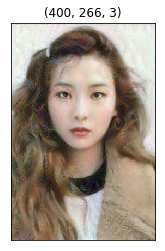

In [311]:
save_weights_path = 'save_model/Vpeople_model_weights_50.hdf5'
train(save_weights_path)

### || People - iteration 51-60 ||
     Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 1e6
    - TV_WEIGHT = 10

In [323]:
model.load_weights('save_model/Vpeople_model_weights_50.hdf5')

In [ ]:
START_IMG_PATH = 'previous_img.png'

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 53296534000000.0
Iteration 0 completed in 227s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 51130800000000.0
Iteration 1 completed in 247s
Start of iteration 2
Current loss value: 49190440000000.0
Iteration 2 completed in 237s
Start of iteration 3
Current loss value: 47388966000000.0
Iteration 3 completed in 239s
Start of iteration 4
Current loss value: 45825644000000.0
Iteration 4 completed in 242s
Start of iteration 5
Current loss value: 44498256000000.0
Iteration 5 completed in 239s
Start of iteration 6
Current loss value: 43312290000000.0
Iteration 6 completed in 233s
Start of iteration 7
Current loss value: 41999280000000.0
Iteration 7 completed in 228s
Start of iteration 8
Current loss value: 40883540000000.0
Iteration 8 completed in 231s
Start of iteration 9
Current loss value: 39919210000000.0
Iteration 9 completed in 202s


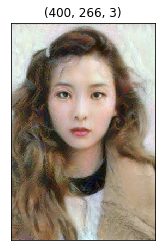

In [324]:
save_weights_path = 'save_model/Vpeople_model_weights_60.hdf5'
train(save_weights_path)

### || People - iteration 61-70 ||
     Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 1e7
    - TV_WEIGHT = 10

In [330]:
model.load_weights('save_model/Vpeople_model_weights_60.hdf5')

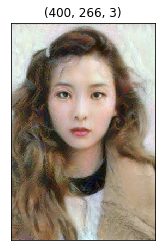

In [331]:
START_IMG_PATH = 'previous_img.png'
visualize_image(START_IMG_PATH)

In [ ]:
START_IMG_PATH = 'previous_img.png'

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 38149456000000.0
Iteration 0 completed in 216s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 37092516000000.0
Iteration 1 completed in 206s
Start of iteration 2
Current loss value: 36221137000000.0
Iteration 2 completed in 235s
Start of iteration 3
Current loss value: 35448280000000.0
Iteration 3 completed in 215s
Start of iteration 4
Current loss value: 34777632000000.0
Iteration 4 completed in 196s
Start of iteration 5
Current loss value: 34054982000000.0
Iteration 5 completed in 201s
Start of iteration 6
Current loss value: 33402286000000.0
Iteration 6 completed in 213s
Start of iteration 7
Current loss value: 32611722000000.0
Iteration 7 completed in 231s
Start of iteration 8
Current loss value: 31889597000000.0
Iteration 8 completed in 219s
Start of iteration 9
Current loss value: 31296504000000.0
Iteration 9 completed in 208s


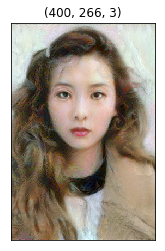

In [332]:
save_weights_path = 'save_model/Vpeople_model_weights_70.hdf5'
train(save_weights_path)

### || People - iteration 71-100 ||
     Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 1e7
    - TV_WEIGHT = 10

In [349]:
model.load_weights('save_model/Vpeople_model_weights_60.hdf5')

In [350]:
START_IMG_PATH = 'previous_img.png'

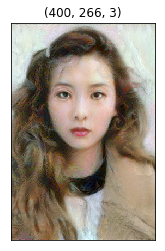

In [351]:
visualize_image(START_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 301930000000000.0
Iteration 0 completed in 194s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 296864180000000.0
Iteration 1 completed in 184s
Start of iteration 2
Current loss value: 292237160000000.0
Iteration 2 completed in 181s
Start of iteration 3
Current loss value: 288062500000000.0
Iteration 3 completed in 180s
Start of iteration 4
Current loss value: 283927700000000.0
Iteration 4 completed in 180s
Start of iteration 5
Current loss value: 279269200000000.0
Iteration 5 completed in 179s
Start of iteration 6
Current loss value: 274149000000000.0
Iteration 6 completed in 181s
Start of iteration 7
Current loss value: 269845250000000.0
Iteration 7 completed in 182s
Start of iteration 8
Current loss value: 266173720000000.0
Iteration 8 completed in 180s
Start of iteration 9
Current loss value: 261980300000000.0
Iteration 9 completed in 204s
Start of iteration 10
Current loss value: 257632570000000.0
Iteration 10 completed in 216s
Start of iteration 11
Current loss value: 254447320000000.0
Iteration 11 completed in 199s
Start of iteration 12
Current loss val

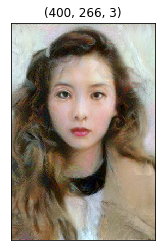

In [352]:
save_weights_path = 'save_model/Vpeople_model_weights_100.hdf5'
train(save_weights_path)

### || People - iteration 101-150 ||
     Hyperparameters:
    - CONTENT_WEIGHT = 2 
    - STYLE_WEIGHT = 1e7
    - TV_WEIGHT = 10

In [361]:
model.load_weights('save_model/Vpeople_model_weights_100.hdf5')

In [362]:
START_IMG_PATH = 'previous_img.png'

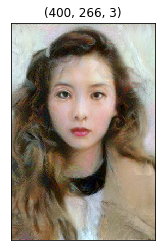

In [363]:
visualize_image(START_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 195299440000000.0
Iteration 0 completed in 214s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 192584670000000.0
Iteration 1 completed in 213s
Start of iteration 2
Current loss value: 190251180000000.0
Iteration 2 completed in 241s
Start of iteration 3
Current loss value: 188308760000000.0
Iteration 3 completed in 242s
Start of iteration 4
Current loss value: 186550710000000.0
Iteration 4 completed in 239s
Start of iteration 5
Current loss value: 185041420000000.0
Iteration 5 completed in 238s
Start of iteration 6
Current loss value: 183650590000000.0
Iteration 6 completed in 202s
Start of iteration 7
Current loss value: 182100190000000.0
Iteration 7 completed in 245s
Start of iteration 8
Current loss value: 180578630000000.0
Iteration 8 completed in 222s
Start of iteration 9
Current loss value: 179304650000000.0
Iteration 9 completed in 205s
Start of iteration 10
Current loss value: 177093210000000.0
Iteration 10 completed in 237s
Start of iteration 11
Current loss value: 174946500000000.0
Iteration 11 completed in 231s
Start of iteration 12
Current loss val

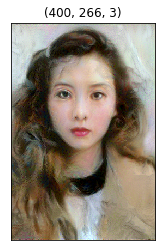

In [364]:
save_weights_path = 'save_model/Vpeople_model_weights_150.hdf5'
train(save_weights_path)

In [14]:
model.load_weights('save_model/Vpeople_model_weights_150.hdf5')

In [15]:
START_IMG_PATH = 'previous_img.png'

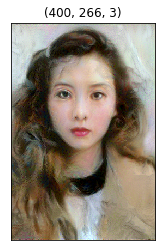

In [16]:
visualize_image(START_IMG_PATH)

/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


Start of iteration 0
Current loss value: 129739150000000.0
Iteration 0 completed in 197s
Start of iteration 1


/Users/Claire/anaconda3/envs/udacitydp/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss value: 126870155000000.0
Iteration 1 completed in 195s
Start of iteration 2
Current loss value: 125588224000000.0
Iteration 2 completed in 193s
Start of iteration 3
Current loss value: 124576610000000.0
Iteration 3 completed in 221s
Start of iteration 4
Current loss value: 123725060000000.0
Iteration 4 completed in 190s
Start of iteration 5
Current loss value: 122917260000000.0
Iteration 5 completed in 182s
Start of iteration 6
Current loss value: 122002780000000.0
Iteration 6 completed in 240s
Start of iteration 7
Current loss value: 121215740000000.0
Iteration 7 completed in 192s
Start of iteration 8
Current loss value: 120605316000000.0
Iteration 8 completed in 185s
Start of iteration 9
Current loss value: 120010860000000.0
Iteration 9 completed in 185s
Start of iteration 10
Current loss value: 119094485000000.0
Iteration 10 completed in 184s
Start of iteration 11
Current loss value: 118243470000000.0
Iteration 11 completed in 186s
Start of iteration 12
Current loss val

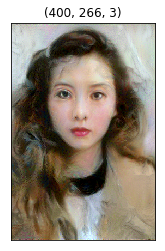

In [20]:
save_weights_path = 'save_model/Vpeople_model_weights_200.hdf5'
train(save_weights_path)

## Reference

1. [Image Style Transfer Using Convolutional Neural Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)
2. [Perceptual Losses for Real-Time Style Transfer
and Super-Resolution](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16.pdf)